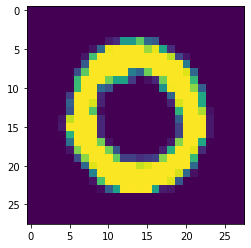

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('./data/digit.csv')
train = train.drop(['label'], axis=1)
data = train[:64].to_numpy().reshape(64, 1, 28, 28)
_ = plt.imshow(data[1].reshape(28,28))

In [2]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_channels=1, img_size=28):
        super(Generator, self).__init__()
        
        self.in_c = in_channels
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm1d(256, 0.1),
            nn.Linear(256, 512), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm1d(512, 0.1),
            nn.Linear(512, 1024), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm1d(1024, 0.1),
            nn.Linear(1024, int(np.prod((self.in_c, self.img_size, self.img_size)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), self.in_c, self.img_size, self.img_size)


class Discriminator(nn.Module):
    def __init__(self, in_channels=1, img_size=28):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_channels*img_size**2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        return self.model(img_flat)

class Config:
    n_epochs = 50
    batch_size = 8
    lr = 0.0003
    latent_dim = 100     # dimension of inputs
    img_size = 28
    d_steps = 1          # discriminator update steps

opt = Config()

# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(img_size=opt.img_size)
discriminator = Discriminator(img_size=opt.img_size)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr)

batch_num = len(data)//opt.batch_size
for epoch in range(opt.n_epochs):
    for i in range(batch_num):
        imgs = torch.Tensor(data[i:i+opt.batch_size])

        # labels
        label_real = torch.ones(opt.batch_size, 1)
        label_fake = torch.zeros(opt.batch_size, 1)

        for j in range(opt.d_steps):
            # normal distribution noise
            z = torch.Tensor(np.random.normal(0, 1, size=(opt.batch_size, opt.latent_dim)))
            # generate target distribution data
            gen_imgs = generator(z)

            # update discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(imgs), label_real)
            fake_loss = criterion(discriminator(gen_imgs.detach()), label_fake)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()
        
        # update generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs), label_real)
        g_loss.backward()
        optimizer_G.step() # only updates the parameters of generator

        if (epoch+1) % 5 == 0 and (i+1) % 8 == 0: 
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1, opt.n_epochs, i+1, batch_num, d_loss.item(), g_loss.item())
            )

[Epoch 5/50] [Batch 8/8] [D loss: 0.679962] [G loss: 0.732385]
[Epoch 10/50] [Batch 8/8] [D loss: 0.584665] [G loss: 0.850403]
[Epoch 15/50] [Batch 8/8] [D loss: 1.051279] [G loss: 0.600967]
[Epoch 20/50] [Batch 8/8] [D loss: 1.108815] [G loss: 0.581483]
[Epoch 25/50] [Batch 8/8] [D loss: 0.626518] [G loss: 1.130054]
[Epoch 30/50] [Batch 8/8] [D loss: 0.142171] [G loss: 3.431426]
[Epoch 35/50] [Batch 8/8] [D loss: 0.146890] [G loss: 6.406354]
[Epoch 40/50] [Batch 8/8] [D loss: 0.052916] [G loss: 4.998194]
[Epoch 45/50] [Batch 8/8] [D loss: 0.319150] [G loss: 5.021058]
[Epoch 50/50] [Batch 8/8] [D loss: 0.005324] [G loss: 7.634764]


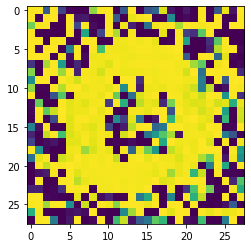

In [3]:
gen = generator(torch.Tensor(np.random.normal(0, 1, size=(opt.batch_size, opt.latent_dim))))
_ = plt.imshow(gen[0][0].detach().numpy())